In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
import os
from datetime import datetime
from dateutil import parser
import matplotlib as mpl
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from astropy.time import Time
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
import cmath
import copy
%matplotlib inline

from scipy.signal import medfilt
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
from chara_uvcalc import uv_calc
from binary_disk_point import binary_disk_point
from binary_disks_vector import binary_disks_vector

plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10

eachindex = lambda lst: range(len(lst))

## Select the nights / directory

In [2]:
## ups and
date = '2023Apr15_mystic'
tar_dir = '/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/'

In [3]:
## Test files to see spectral channels, e.g.
print('n measure, n spectral channels = ')
for file in sorted(os.listdir(tar_dir)):
    if file.endswith('.oifits'):
        filename = os.path.join(tar_dir, file)
        #print(filename)
        hdu = fits.open(filename)
        print(hdu['OI_T3'].data['T3PHI'].shape)
        #print(hdu['OI_WAVELENGTH'].data['EFF_WAVE'])
        hdu.close()

n measure, n spectral channels = 
(4279, 6)
(4275, 6)
(1601, 6)
(826, 6)
(711, 6)
(470, 6)
(271, 6)
(173, 6)
(110, 6)
(63, 6)


In [4]:
nfiles = 10

In [5]:
integration_times = np.array([0.5,1,2,4,5,8,16,32,64,128])

## Load in the data from all nights

In [6]:
## Use calibrators to measure drift with alt/az

t3phi = np.zeros(shape=nfiles,dtype=object)
t3phierr = np.zeros(shape=nfiles,dtype=object)
tels = np.zeros(shape=nfiles,dtype=object)
eff_wave = np.zeros(shape=nfiles,dtype=object)
time_obs = np.zeros(shape=nfiles,dtype=object)
az = np.zeros(shape=nfiles,dtype=object)
alt = np.zeros(shape=nfiles,dtype=object)

#new data:
beam_map = {1:'S1',2:'S2',3:'E1',4:'E2',5:'W1',6:'W2'}
#older data:
#beam_map = {0:'S1',1:'S2',2:'E1',3:'E2',4:'W1',5:'W2'}
    
print('----'*10)
print('Load Target DATA')
print('----'*10)

chara = EarthLocation(lat=34.2259*u.deg, lon=-118.0571*u.deg, height=1734*u.m)
idx = 0
for file in sorted(os.listdir(tar_dir)):
    
    if file.endswith('.oifits'):
        
        t3phi_file = []
        t3phierr_file = []
        tels_file = []
        eff_wave_file = []
        time_obs_file = []
        alt_file = []
        az_file = []
    
        filename = os.path.join(tar_dir, file)
        print(filename)
        hdu = fits.open(filename)
        
        ra_deg = hdu['OI_TARGET'].data['RAEP0']
        dec_deg = hdu['OI_TARGET'].data['DECEP0']
        coord_icrs = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame='icrs')
    
        for table in hdu:
            
            #if table.name=='OI_WAVELENGTH':
            #    eff_wave.append(table.data['EFF_WAVE'][1:33])
            
            ## t3phi data:
            wl_i=1
            if table.name=='OI_T3':
                for i in eachindex(table.data):
                    t3 = table.data[i]['T3PHI']
                    t3err = table.data[i]['T3PHIERR']
                    t3flag = np.where(table.data[i].field('FLAG')==True)
                    t3[t3flag] = np.nan
                    t3err[t3flag] = np.nan
                    t3phi_file.append(t3)
                    t3phierr_file.append(t3err)
                    tels_file.append([beam_map[a] for a in table.data[i]['STA_INDEX']])
                    eff_wave_file.append(hdu['OI_WAVELENGTH',wl_i].data['EFF_WAVE'])
                    time = table.data[i]['MJD']
                    time_obs_file.append(time)
                    
                    t = Time(time,format='mjd',location=chara)
                    sidereal = t.sidereal_time('apparent')
                    aa = AltAz(location=chara, obstime=t)
                    alt_file.append(coord_icrs.transform_to(aa).alt.deg[0])
                    az_file.append(coord_icrs.transform_to(aa).az.deg[0])
                    
                wl_i+=1
                
        hdu.close()
        
        t3phi_file = np.array(t3phi_file)
        t3phierr_file = np.array(t3phierr_file)
        tels_file = np.array(tels_file)
        eff_wave_file = np.array(eff_wave_file)
        time_obs_file = np.array(time_obs_file)
        alt_file = np.array(alt_file)
        az_file = np.array(az_file)
    
        t3phi[idx] = t3phi_file
        t3phierr[idx] = t3phierr_file
        tels[idx] = tels_file
        eff_wave[idx] = eff_wave_file
        time_obs[idx] = time_obs_file
        alt[idx] = alt_file
        az[idx] = az_file
    
        idx+=1    

----------------------------------------
Load Target DATA
----------------------------------------
/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/MIRCX_L2.2023Apr15.HD_120136...TG_Cal.AVG000m.MEDFILT.oifits
/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/MIRCX_L2.2023Apr15.HD_120136...TG_Cal.AVG001m.MEDFILT.oifits
/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/MIRCX_L2.2023Apr15.HD_120136...TG_Cal.AVG002m.MEDFILT.oifits
/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/MIRCX_L2.2023Apr15.HD_120136...TG_Cal.AVG004m.MEDFILT.oifits
/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/MIRCX_L2.2023Apr15.HD_120136...TG_Cal.AVG005m.MEDFILT.oifits
/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/MIRCX_L2.2023Apr15.HD_120136...TG_Cal.AVG008m.MEDFILT.oifits
/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/MIRCX_L2.2023Apr15.HD_120136...TG_Cal.AVG016m.MEDFILT.oifits
/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/MIRCX_L2.2023Apr15

In [7]:
#plt.plot(t3phi - t3phi_cal)
print(t3phi.shape)
print(time_obs.shape)

(10,)
(10,)


In [8]:
print(t3phi[0].shape)
print(time_obs[0].shape)

(4279, 6)
(4279,)


In [9]:
## Compute stddev for each triangle and integration time
stdev = []
stdev_tel = []
for phase,tel in zip(t3phi,tels):
    
    stdev_file = []
    stdev_tel_file = []
    
    unique_tels = np.unique(tel,axis=0)
    index = np.arange(len(unique_tels))
    
    for ind in index:
        t3data=[]
        for t,tri in zip(phase,tel):
            if str(tri)==str(unique_tels[int(ind)]):
                t3data.append(t)
        t3data=np.array(t3data)

        t3_std=np.nanstd(t3data,axis=0)
        stdev_file.append(t3_std)
        stdev_tel_file.append(unique_tels[int(ind)])
        
    stdev_file = np.array(stdev_file)
    stdev_tel_file = np.array(stdev_tel_file)
    
    stdev.append(stdev_file)
    stdev_tel.append(stdev_tel_file)

stdev = np.array(stdev)
stdev_tel = np.array(stdev_tel)

In [10]:
print(stdev.shape)
print(stdev_tel.shape)

(10, 20, 6)
(10, 20, 3)


In [11]:
xdata = integration_times
ydata = stdev[:,7,3]

popt, pcov = curve_fit(lambda t, a, b: a * t**(-b), xdata, ydata)
a = popt[0]
b = popt[1]
#c = popt[2]
ymodel = a*xdata**(-b)# + c

plt.plot(integration_times,stdev[:,7,3],'o--')
plt.plot(integration_times,ymodel,'--',label="exponent = %s"%np.around(-b,3))
plt.xscale('log')
plt.legend()
plt.show()

In [12]:
label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

fig,axs = plt.subplots(4,5,figsize=(15,10),facecolor='w',edgecolor='k')
index = np.arange(20)

fig.subplots_adjust(hspace=0.5,wspace=.001)
axs=axs.ravel()

channel = 3

for ind in index:
    
    xdata=integration_times
    ydata=stdev[:,ind,channel]
    popt, pcov = curve_fit(lambda t, a, b: a * t**(-b), xdata, ydata)
    a = popt[0]
    b = popt[1]
    #c = popt[2]
    ymodel = a*xdata**(-b)#+c
    
    axs[int(ind)].plot(xdata,ydata,'o--',color='black')
    axs[int(ind)].plot(xdata,ymodel,'--',color='grey', label=np.around(-b,2))
    axs[int(ind)].set_title(str(stdev_tel[0,int(ind),:]))
    axs[int(ind)].set_xscale('log')
    #axs[int(ind)].set_yscale('log')
    axs[int(ind)].legend(loc=9)

fig.suptitle('Tau Boo SNR Test')
fig.text(0.5, 0.07, 'Integration Time (minutes)', ha='center')
fig.text(0.08, 0.5, 'T3PHI std dev (degrees)', va='center', rotation='vertical')
plt.show()

## Now remove systematics based off of model:

In [13]:
telmod = np.load('/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/calibration/2023Apr_mystic_telmod.npy')
a0mod = np.load('/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/calibration/2023Apr_mystic_a0mod.npy')
a1mod = np.load('/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/calibration/2023Apr_mystic_a1mod.npy')
a2mod = np.load('/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/calibration/2023Apr_mystic_a2mod.npy')
a3mod = np.load('/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/calibration/2023Apr_mystic_a3mod.npy')
a4mod = np.load('/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/calibration/2023Apr_mystic_a4mod.npy')
a5mod = np.load('/Users/tgardner/data/2023Apr15_snr_test/mystic/2023Apr15/calibration/2023Apr_mystic_a5mod.npy')

In [14]:
## apply correction based on cals
t3phi_old = copy.deepcopy(t3phi)

print(t3phi[5][0,0])
print(t3phi_old[5][0,0])

for idx,t3_n in enumerate(t3phi):
    
    n_data = np.arange(t3_n.shape[0])
    n_channels = np.arange(t3_n.shape[1])

    ## apply correction based on cals -- Ming model
    for i in n_data:
        for tri,a0,a1,a2,a3,a4,a5 in zip(telmod,a0mod,a1mod,a2mod,a3mod,a4mod,a5mod):
            if str(tri)==str(tels[idx][i]):
                
                #if 'E1' in str(tri) and 'W2' in str(tri) and 'W1' in str(tri):
                #    print('Skipping E1-W2-W1')
                #    continue
                        
                for j in n_channels:
                    x1 = az[idx][i]
                    x2 = alt[idx][i]
                    x1 = ((x1*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
                    x2 = ((x2*np.pi/180 + np.pi) % (2 * np.pi) - np.pi )*180/np.pi
                    t3model = a0[j] + a1[j]*x1 + a2[j]*x1**2 + a3[j]*x1*x2 + a4[j]*x2 + a5[j]*x2**2
                    t3phi[idx][i][j] -= t3model
                    
print(t3phi[5][0,0])
print(t3phi_old[5][0,0])

0.2409152090549469
0.2409152090549469
-0.2278962723156187
0.2409152090549469


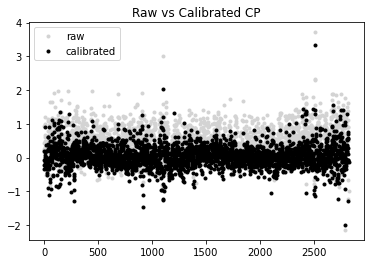

In [34]:
plt.plot(np.ndarray.flatten(t3phi_old[5]),'.',color='lightgrey',label='raw')
plt.plot(np.ndarray.flatten(t3phi[5]),'.',color='black',label='calibrated')
plt.legend()
plt.title("Raw vs Calibrated CP")
plt.show()

In [19]:
## Compute stddev for each triangle and integration time
stdev = []
stdev_tel = []
for phase,tel in zip(t3phi,tels):
    
    stdev_file = []
    stdev_tel_file = []
    
    unique_tels = np.unique(tel,axis=0)
    index = np.arange(len(unique_tels))
    
    for ind in index:
        t3data=[]
        for t,tri in zip(phase,tel):
            if str(tri)==str(unique_tels[int(ind)]):
                t3data.append(t)
        t3data=np.array(t3data)

        t3_std=np.nanstd(t3data,axis=0)
        stdev_file.append(t3_std)
        stdev_tel_file.append(unique_tels[int(ind)])
        
    stdev_file = np.array(stdev_file)
    stdev_tel_file = np.array(stdev_tel_file)
    
    stdev.append(stdev_file)
    stdev_tel.append(stdev_tel_file)

stdev = np.array(stdev)
stdev_tel = np.array(stdev_tel)

In [20]:
label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

fig,axs = plt.subplots(4,5,figsize=(15,10),facecolor='w',edgecolor='k')
index = np.arange(20)

fig.subplots_adjust(hspace=0.5,wspace=.001)
axs=axs.ravel()

channel = 3

for ind in index:
    
    xdata=integration_times
    ydata=stdev[:,ind,channel]
    popt, pcov = curve_fit(lambda t, a, b: a * t**(-b), xdata, ydata)
    a = popt[0]
    b = popt[1]
    #c = popt[2]
    ymodel = a*xdata**(-b)#+c
    
    axs[int(ind)].plot(xdata,ydata,'o--',color='black')
    axs[int(ind)].plot(xdata,ymodel,'--',color='grey', label=np.around(-b,2))
    axs[int(ind)].set_title(str(stdev_tel[0,int(ind),:]))
    axs[int(ind)].set_xscale('log')
    #axs[int(ind)].set_yscale('log')
    axs[int(ind)].legend(loc=9)

fig.suptitle('Tau Boo SNR Test')
fig.text(0.5, 0.07, 'Integration Time (minutes)', ha='center')
fig.text(0.08, 0.5, 'T3PHI std dev (degrees)', va='center', rotation='vertical')
plt.show()